In [8]:
from enum import Enum
import numpy as np
import pandas as pd
import math as m
from pathlib import Path

base_directory = "D:/Descargas/i2ascii-files/i2ascii-files/"

class STATE(Enum):
    EVENT_ID = 1
    RUN_INFO = 2
    WEIGHTS = 3
    NEUTRINO = 4
    MUON = 5
    AAFIT = 6
    BBFIT_TRACK = 7
    BBFIT_BRIGHT = 8
    GRIDFIT = 9
    HITS = 10
    SELECTED_HITS = 11
    
def event_id (line, event, state, df_list):
    if "start_event" in line:
        event["event_id"] = line.split()[1]
        state = STATE.RUN_INFO
      #  print("START EVENT: " + event["event_id"])
    return event, state
        
def run_info (line, event, state, df_list):
    element_list = line.split()
    if len(element_list) == 7: 
        event["run_id"] = element_list[0]
        event["frame_id"] = element_list[1]
        event["trigger_counter"] = element_list[2]
        event["date"] = element_list[4]
        event["time"] = element_list[5].split(",")[0]
        state = STATE.WEIGHTS
    else:
        print("ERROR IN STATE: RUN_INFO")
    return event, state

def weights (line, event, state, df_list):
    element_list = line.split()
    if len(element_list) == 4 and element_list[0] == "weights": 
        event["w_1"] = element_list[1]
        event["w_2"] = element_list[2]
        event["w_3"] = element_list[3]
        state = STATE.NEUTRINO
    else:
        print("ERROR IN STATE: WEIGHTS")
    return event, state

def cart2sph(x,y,z):
    x = float(x)
    y = float(y)
    z = float(z)
    XsqPlusYsq = x**2 + y**2
    r = m.sqrt(XsqPlusYsq + z**2)               # r
    elev = m.atan2(z,m.sqrt(XsqPlusYsq))     # theta
    az = m.atan2(y,x)                           # phi
    return elev, az

def neutrino (line, event, state, df_list):
    element_list = line.split()
    if len(element_list) == 9 and element_list[0] == "nu": 
    #    event["n_elev"], event["n_az"] = cart2sph(element_list[1], element_list[2], element_list[3])
        # event["n_dir_x"] = element_list[1]
        # event["n_dir_y"] = element_list[2]
        # event["n_dir_z"] = element_list[3]
    #    event["n_pos_x"] = element_list[4]
    #    event["n_pos_y"] = element_list[5]
    #    event["n_pos_z"] = element_list[6]
    #    event["n_energy"] = element_list[7]
        state = STATE.MUON
    else:
        print("ERROR IN STATE: NEUTRINO")
    return event, state
   
def muon (line, event, state, df_list):
    element_list = line.split()
    if len(element_list) == 9 and element_list[0] == "muon": 
        event["m_elev"], event["m_az"] = cart2sph(element_list[1], element_list[2], element_list[3])
        event["m_dir_x"] = element_list[1]
        event["m_dir_y"] = element_list[2]
        event["m_dir_z"] = element_list[3]
        event["m_pos_x"] = element_list[4]
        event["m_pos_y"] = element_list[5]
        event["m_pos_z"] = element_list[6]
        event["m_energy"] = element_list[7]
        state = STATE.AAFIT
    else:
        print("ERROR IN STATE: MUON")
    return event, state

def aafit (line, event, state, df_list):
    element_list = line.split()
    if len(element_list) == 9 and element_list[0] == "aafit":
        event["aafit_elev"], event["aafit_az"] = cart2sph(element_list[1], element_list[2], element_list[3])
        #event["aafit_dir_x"] = element_list[1]
        #event["aafit_dir_y"] = element_list[2]
        #event["aafit_dir_z"] = element_list[3]
        event["aafit_lambda"] = element_list[7]
        event["aafit_beta"] = element_list[8]
        state = STATE.BBFIT_TRACK
    else:
        state = STATE.EVENT_ID
    #    print("ERROR IN STATE: AAFIT -> Event " + event["event_id"])
    return event, state
    
def bbfit_track (line, event, state, df_list):
    element_list = line.split()
    if len(element_list) == 8 and element_list[0] == "bbfit_track":
        
        if element_list[1] == "nan" or element_list[2] == "nan" or element_list[3] == "nan":
            state = STATE.EVENT_ID
          #  print("BBFIT_TRACK NOT FOUND -> Event " + event["event_id"])
        else:
            event["bbfit_elev"], event["bbfit_az"] = cart2sph(
                0 if element_list[1] == "nan" else element_list[1],
                0 if element_list[2] == "nan" else element_list[2],
                0 if element_list[3] == "nan" else element_list[3])
            # event["bbfit_dir_x"] = np.nan if element_list[1] == "nan" else element_list[1]
            event["bbfit_dir_x"] = 0 if element_list[1] == "nan" else element_list[1]
            event["bbfit_dir_y"] = 0 if element_list[2] == "nan" else element_list[2]
            event["bbfit_dir_z"] = 0 if element_list[3] == "nan" else element_list[3]
            event["bbfit_chi2"] = element_list[7]
            state = STATE.BBFIT_BRIGHT
    else:
        print("ERROR IN STATE: BBFIT_TRACK")
    return event, state

def bbfit_bright (line, event, state, df_list):
    element_list = line.split()
    if len(element_list) == 8 and element_list[0] == "bbfit_bright": 
        state = STATE.GRIDFIT
    else:
        print("ERROR IN STATE: BBFIT_BRIGHT")
    return event, state
    
def gridfit (line, event, state, df_list):
    element_list = line.split()
    if len(element_list) == 8 and element_list[0] == "gridfit": 
        state = STATE.HITS
    elif element_list[0] == "hit":
        # Some times there are not gridfit measures...
        return hits(line, event, state, df_list)
    else:
        print("ERROR IN STATE: GRIDFIT")
    return event, state

def hits (line, event, state, df_list):
    element_list = line.split()
    if len(element_list) == 14 and element_list[0] == "hit":
        state = STATE.HITS
    elif len(element_list) == 3 and element_list[0] == "BBFit": 
        state = STATE.SELECTED_HITS
    else:
        print("ERROR IN STATE: HITS")
    return event, state
   
def selected_hits (line, event, state, df_list):
    element_list = line.split()
    if len(element_list) == 14 and element_list[0] == "hit": 
        state = STATE.SELECTED_HITS
    elif "end_event" in line:
        state = STATE.EVENT_ID
        temp_event = event.copy()
        df_list.append(temp_event)
        event['det_type'] = temp_event['det_type']
        #print("END EVENT: " + event["event_id"])
    else:
        print("ERROR IN STATE: SELECTED_HITS")
    return event, state
   
state_dict = {
    STATE.EVENT_ID: event_id,
    STATE.RUN_INFO: run_info,
    STATE.WEIGHTS: weights,
    STATE.NEUTRINO: neutrino,
    STATE.MUON: muon,
    STATE.AAFIT: aafit,
    STATE.BBFIT_TRACK: bbfit_track,
    STATE.BBFIT_BRIGHT: bbfit_bright,
    STATE.GRIDFIT: gridfit,
    STATE.HITS: hits,
    STATE.SELECTED_HITS: selected_hits
}

In [ ]:
pathlist = Path(base_directory).glob('*.txt')
counter = 0;
df_list = []
for path in pathlist:
    # because path is object not string
    path_in_str = str(path)
  #  print("\nFILE: " + path_in_str)
    detection_type = 1 if "anumu" in path_in_str else 2
    with open(path_in_str, "r") as f_test:
        line = f_test.readline()
        current_state = STATE.EVENT_ID
        current_event = {}
        current_event['det_type'] = detection_type
        while line:
            current_event, current_state = state_dict[current_state](line, current_event, current_state, df_list)
            line = f_test.readline()
            
    counter += 1
    if counter > 2000:
        break;
    
df = pd.DataFrame(df_list)
#print(df)

In [ ]:
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer

# Métricas de evaluación que se utilizarán. No nos preocupamos en negarlas debido a que no se utilizarán de forma automática,
# solo las visualizaremos
metrics_dict = {
  'MAE': metrics.mean_absolute_error,
  'RMSE': lambda y, y_pred:
          sqrt(metrics.mean_squared_error(y, y_pred)),
 # 'MAPE': lambda y, y_pred:
 #         np.mean(np.abs((y - y_pred) / y)) * 100,
  'E_VARIANCE': metrics.explained_variance_score
}

algorithms_dict = {}

# Algoritmo 1: Estandarización + OLS
#steps = [('standardization', StandardScaler()),
#         ('elastic', ElasticNet())]
#algorithms_dict['STD_ELASTIC'] = Pipeline(steps)

# Algoritmo 2: Estandarización + KNN
#steps = [('standardization', StandardScaler()),
#         ('laso', Lasso())]
#algorithms_dict['STD_LASO'] = Pipeline(steps)

# Algoritmo 2: Estandarización + KNN
#steps = [('standardization', StandardScaler()),
#         ('knn', KNeighborsRegressor(n_neighbors=10))]
#algorithms_dict['STD_KNN'] = Pipeline(steps)

# Algoritmo 3: Estandarización + RandomForest
steps = [('standardization', StandardScaler()),
         ('rforest', RandomForestRegressor(n_estimators=150, min_samples_leaf=5,
                                          max_features=0.4, criterion='mse', max_depth=10))]
algorithms_dict['STD_RF'] = Pipeline(steps)

# Algoritmo 4: Estandarización + Gradient Boosting
#steps = [('standardization', StandardScaler()),
#         ('gbr', GradientBoostingRegressor(n_estimators=200, max_depth=3))]
#algorithms_dict['STD_GBR'] = Pipeline(steps)

# Algoritmo 3: Estandarización + Gradient Boosting
#steps = [('standardization', StandardScaler()),
#         ('pca', PCA(n_components=0.95)),
#         ('rforest', RandomForestRegressor())]
#algorithms_dict['STD_RF_NO_STD'] = Pipeline(steps)

In [ ]:
df.columns

In [ ]:
target = df[['m_elev','m_az']]
data = df.drop(['m_elev', 'm_az', 'event_id', 'run_id', 'date', 'time', 'm_energy', 'm_pos_x', 'm_pos_y', 'm_pos_z',
                   'm_dir_x', 'm_dir_y', 'm_dir_z','bbfit_dir_x','bbfit_dir_y','bbfit_dir_z', 'frame_id',], axis=1)
target2 = target['m_az']

In [ ]:
type(data['aafit_az'][0])

In [23]:
df.count()

aafit_az           870241
aafit_beta         870241
aafit_elev         870241
aafit_lambda       870241
bbfit_az           870241
bbfit_chi2         870241
bbfit_dir_x        870241
bbfit_dir_y        870241
bbfit_dir_z        870241
bbfit_elev         870241
date               870241
det_type           870241
event_id           870241
frame_id           870241
m_az               870241
m_dir_x            870241
m_dir_y            870241
m_dir_z            870241
m_elev             870241
m_energy           870241
m_pos_x            870241
m_pos_y            870241
m_pos_z            870241
run_id             870241
time               870241
trigger_counter    870241
w_1                870241
w_2                870241
w_3                870241
dtype: int64

In [ ]:
from sklearn.ensemble import IsolationForest

#n_samples = df.count()
#outliers_fraction = 0.1
#n_outliers = int(outliers_fraction * n_samples)
#n_inliers = n_samples - n_outliers

# fit the model
clf = IsolationForest(behaviour='new',n_jobs=4,
                      random_state=50, contamination='auto')

outliers_mask = clf.fit(data).predict(data)

In [ ]:
outliers_mask2 = outliers_mask

In [ ]:
num_neg = (outliers_mask2 == -1).sum()
print(num_neg)
num_pos = (outliers_mask2 == 1).sum()
print(num_pos)

In [ ]:
data_filtered = data[outliers_mask > 0]

In [31]:
data_filtered.count()

aafit_az           799868
aafit_beta         799868
aafit_elev         799868
aafit_lambda       799868
bbfit_az           799868
bbfit_chi2         799868
bbfit_elev         799868
det_type           799868
trigger_counter    799868
w_1                799868
w_2                799868
w_3                799868
dtype: int64

In [34]:
target_filtered = target[outliers_mask > 0]

In [ ]:
#cv_results = cross_val_predict(algorithms_dict['STD_RF'], data, target, n_jobs=4,
#                                                              cv=KFold(n_splits=5, random_state=50))

In [114]:
#print('TEST SCORE: ' + str(cv_results['test_score']))
#print('TRAIN SCORE: ' + str(cv_results['train_score']))

TEST SCORE: [0.73076817 0.78401552 0.75446311 0.75903081 0.78468517]
TRAIN SCORE: [0.77417334 0.76145543 0.76817786 0.76722084 0.75988962]


In [115]:
#cv_results

{'fit_time': array([149.29266882, 152.651649  , 150.86225271, 151.49362421,
        144.29238558]),
 'score_time': array([1.40358043, 1.44558144, 1.40056276, 1.45732832, 1.43694735]),
 'test_score': array([0.73076817, 0.78401552, 0.75446311, 0.75903081, 0.78468517]),
 'train_score': array([0.77417334, 0.76145543, 0.76817786, 0.76722084, 0.75988962])}

In [35]:
# Se realizan las 6 predicciones y se almacenan en un diccionario con nombres descriptivos 
y_pred_dict = {}
for alg_name, alg in algorithms_dict.items():
    y_pred_dict[alg_name] = cross_val_predict(alg, data_filtered, target_filtered, n_jobs=4,
                                                              cv=KFold(n_splits=5, random_state=50))

In [36]:
# En lugar de importar la función del script utilizado en clase, se reimplementa con ligeras variaciones para
# adaptarse a las necesidades del ejercicio
def grafica_real_vs_pred_mod(y_true, y_pred, evaluated_metrics, algorithm_name):
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Real class value')
    ax.set_ylabel('Prediction')
    title = algorithm_name + '\n'
    for name, result in evaluated_metrics.items():
        title += name + ': ' + str(round(result, 3)) + ' '
        
    plt.title(title)
    plt.show()

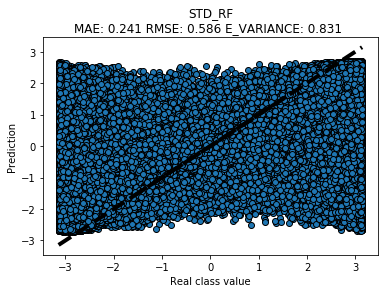

In [39]:
# TEST 1
# Se evaluan las predicciones y se representan al estilo visto en clase
evaluated = {}
for name, prediction in y_pred_dict.items():
    for metric_name, metric in metrics_dict.items():
        evaluated[metric_name] = metric(target_filtered, prediction)

    grafica_real_vs_pred_mod(target_filtered, prediction, evaluated, name)

In [42]:
metrics_dict['MAE'](data[['bbfit_elev','bbfit_az']][outliers_mask > 0], target_filtered)
#metrics_dict['MAE'](data[['bbfit_az']], target2)

0.24572257433830544

In [43]:
metrics_dict['RMSE'](data[['bbfit_elev','bbfit_az']][outliers_mask > 0], target_filtered)
#metrics_dict['RMSE'](data[['bbfit_az']], target2)

0.7503664852503465

In [44]:
visual_comp = target_filtered.join(pd.DataFrame(data[['bbfit_elev','bbfit_az']][outliers_mask > 0]))

In [47]:
visual_comp_all = visual_comp.join(pd.DataFrame(prediction))

In [48]:
visual_comp_all

,m_elev,m_az,bbfit_elev,bbfit_az,0,1
0,0.832965,2.819365,0.843651,2.794801,0.846489,2.648480
1,0.845083,1.372126,0.795489,1.582917,0.801693,1.482559
2,0.991368,1.899561,0.906139,2.225389,0.897936,2.332118
3,0.763149,-0.386265,0.783040,-0.381602,0.759037,-0.489474
4,0.656321,-0.449445,0.649963,-0.499170,0.642454,-0.504024
5,0.712078,0.129850,0.693460,0.272021,0.682332,0.306328
6,0.985847,-0.073609,0.982151,-0.062498,0.976138,-0.217741
7,1.261533,-0.551811,1.252897,-0.504589,1.151380,-0.776279
8,0.615688,-0.767968,0.596053,-0.524840,0.605509,-0.501159
9,0.220327,2.423507,0.213065,2.471685,0.171477,2.469440


In [23]:
y_pred_dict['STD_RF']

array([[ 0.8364946 ,  2.70808922],
       [ 0.7762894 ,  1.14667689],
       [ 0.9181273 ,  2.22780827],
       ...,
       [ 0.84153415,  0.88341351],
       [ 1.11560279, -0.85410034],
       [-0.17241691,  2.33656588]])

In [42]:
#visual_comp = visual_comp.join(pd.DataFrame(y_pred_dict['STD_RF']), rsuffix='pred')

#visual_comp

In [51]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=42)

param_grid = {'n_estimators': [150, 200, 250],
              'max_depth': [4, 6, 8, None],
              'min_samples_split': [0.005, 0.01, 0.015],
              'min_samples_leaf': [5],
              'max_features': [0.35, 0.4, 0.45],
              'criterion': ['mse', 'mae']#metrics_dict.items()
             # 'warm_leaf_nodes': [True, False]
             }

modelo_optimizador = RandomForestRegressor()
gs_cv = GridSearchCV(modelo_optimizador, param_grid, n_jobs=4, cv=5).fit(X_train,y_train)

print(gs_cv.best_params_)
n_estimators = gs_cv.best_params_['n_estimators']
#max_depth = gs_cv.best_params_['max_depth']
min_samples_split = gs_cv.best_params_['min_samples_split']
min_samples_leaf = gs_cv.best_params_['min_samples_leaf']
max_features = gs_cv.best_params_['max_features']
#warm_leaf_nodes = gs_cv.best_params_['warm_leaf_nodes']

{'criterion': 'mse', 'max_depth': None, 'max_features': 0.4, 'min_samples_leaf': 5, 'min_samples_split': 0.005, 'n_estimators': 150}


In [50]:
metrics_dict.items()

dict_items([('MAE', <function mean_absolute_error at 0x000002B59FF84D90>), ('RMSE', <function <lambda> at 0x000002B5A3858598>), ('MAPE', <function <lambda> at 0x000002B5A3858400>), ('E_VARIANCE', <function explained_variance_score at 0x000002B59FF8A048>)])